## 1. Чтение данных
 Мы будем работать с [датасетом](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) для бинарной классификации - определение наличия диабета.

In [150]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('diabetes_prediction_dataset.csv', delimiter=',', header=0)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [151]:
data = dataset.drop(['diabetes'], axis=1)
target = dataset['diabetes']

print(data.shape, target.shape)

(100000, 8) (100000,)


In [152]:
target.value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

Выборка несбалансированная - будем учитывать это при обучении и выборе метрик

In [153]:
rand_st = 61

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, stratify=target, random_state=rand_st)

### 2. Data preprocessing


In [155]:
X_train.head(15)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
62398,Male,80.0,1,0,former,23.98,5.7,130
64317,Male,54.0,0,0,never,29.55,6.6,80
86941,Female,80.0,0,0,former,25.85,4.5,158
93172,Male,63.0,1,0,not current,26.64,4.5,159
70230,Female,16.0,0,0,former,34.13,5.8,160
73542,Male,31.0,0,0,never,36.38,5.8,80
29814,Female,28.0,0,0,not current,25.67,3.5,145
75181,Male,54.0,0,0,never,33.64,6.1,80
47702,Male,36.0,0,0,never,27.32,4.8,158
45105,Female,43.0,1,0,former,28.31,5.7,158


* Сделаем трансформер для кaтегориальных признаков. Также есть признаки в разных шкалах - не помешает нормировка.

In [156]:
data['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

В графе курения, которая, вероятно, одна из наиболее значимых пропущенно слишком много значений. Удалять столбец однако не хочется - внесем его просто в бинарную кодировку, позволив алгоритмам адаптироваться самим.

In [157]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categ = ['gender', 'smoking_history']
numeric = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

ct = ColumnTransformer(
    [("encoder", OneHotEncoder(handle_unknown='ignore'), categ),
     ("scale", StandardScaler(), numeric)]
)

### 3. Resample + выбор модели

Рассмотрим разные методы, балансирующие выборку. Реализации будем брать из библиотеки imblearn, реализацию pipeline тоже оттуда (так как она учитывает отсутствие resample при тесте). Моделями выберем KNN, логистическую регрессию и градиентный бустинг над решающими деревьями. 

Будем смотреть на метрики balanced accuracy, accuracy и precision, recall. $f1 \ score$ дня нашей задачи не очень подходит так как recall для класса 'болен' имеет точно большую значимость - лучше предсказать здоровому диагноз, чем больному его отсутствие, - возьмем $f_{beta}\ score$ c $beta\ = \ 2$ (при более точной оценки значимости можно будеть изменить бету) - причем будем смотреть именно на интересующий нас класс. Точность измеряем с помощью кросс-валидации. Параметры возьмем по умолчанию, потом сделаем подбор на лучших моделях

In [158]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, fbeta_score, make_scorer


from imblearn.pipeline import Pipeline

И сами модели

In [159]:
N_models = 3

models = np.empty(N_models, dtype=object)
models_names = ['KNN', 'Logistic Regression', 'Gradient Boosting Machine']

models[0] = KNeighborsClassifier()
models[1] = LogisticRegression(max_iter=300, random_state=rand_st)
models[2] = GradientBoostingClassifier(random_state=rand_st)

А также метрики точности

In [160]:
metrics_names = {'accuracy': make_scorer(accuracy_score),
                 'balanced_accuracy': make_scorer(balanced_accuracy_score), 
                 'precision': make_scorer(precision_score), 
                 'recall': make_scorer(recall_score), 
                 'f2_score': make_scorer(fbeta_score, beta=2, pos_label=1)}
N_metrics = len(metrics_names)

metrics = np.empty((N_models, N_metrics), dtype='object')

### 3.1 Over-Sampling


1) Random Over Sampler

In [161]:
from imblearn.over_sampling import RandomOverSampler

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', RandomOverSampler(random_state=rand_st)),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

In [162]:
for i, name in enumerate(models_names):
  print(name + ' + RandomOverSampler:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + RandomOverSampler:
accuracy: 0.9206266666666668
balanced_accuracy: 0.8596554162648665
precision: 0.5219818814024764
recall: 0.7861960784313725
f2_score: 0.7138917746175014


Logistic Regression + RandomOverSampler:
accuracy: 0.88764
balanced_accuracy: 0.8850286081645773
precision: 0.4228645589692769
recall: 0.8818823529411765
f2_score: 0.7245394435750517


Gradient Boosting Machine + RandomOverSampler:
accuracy: 0.9064666666666665
balanced_accuracy: 0.9124624450873245
precision: 0.474160371535724
recall: 0.919686274509804
f2_score: 0.7741657166712779




2) [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) & [ADASYN](https://www.activeloop.ai/resources/glossary/adaptive-synthetic-sampling-adasyn/)

In [163]:
from imblearn.over_sampling import ADASYN, SMOTE

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', SMOTE(random_state=rand_st)),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + SMOTE:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + SMOTE:
accuracy: 0.9113866666666667
balanced_accuracy: 0.864495446265938
precision: 0.48725997196098614
recall: 0.808
f2_score: 0.7139547322166692


Logistic Regression + SMOTE:
accuracy: 0.8888533333333333
balanced_accuracy: 0.8849801778634951
precision: 0.42565720408895463
recall: 0.8803137254901963
f2_score: 0.7253333456183052


Gradient Boosting Machine + SMOTE:
accuracy: 0.9565466666666665
balanced_accuracy: 0.8775763420122147
precision: 0.7273234266214625
recall: 0.7824313725490195
f2_score: 0.7706946544298252




In [164]:
for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', ADASYN(random_state=rand_st)),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + ADASYN :')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + ADASYN :
accuracy: 0.8946666666666667
balanced_accuracy: 0.8646077359905711
precision: 0.43692650944791894
recall: 0.8283921568627453
f2_score: 0.7024868692099865


Logistic Regression + ADASYN :
accuracy: 0.8235333333333333
balanced_accuracy: 0.8771751848280296
precision: 0.3182478861395007
recall: 0.9418039215686275
f2_score: 0.67661954824984


Gradient Boosting Machine + ADASYN :
accuracy: 0.9325466666666667
balanced_accuracy: 0.8908565305903782
precision: 0.5702194022234153
recall: 0.8406274509803922
f2_score: 0.767707525894153




Как видим, градиентный бустинг наиболее хорошо справляется с задачей даже без выбора порога

### 3.2. Under-Sampling

1) RandomUnderSampler

In [165]:
from imblearn.under_sampling import RandomUnderSampler

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', RandomUnderSampler(random_state=rand_st)),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + RandomUnderSampler:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + RandomUnderSampler:
accuracy: 0.8712933333333334
balanced_accuracy: 0.8778034929818921
precision: 0.3875300797308844
recall: 0.8856470588235293
f2_score: 0.7045166607263982


Logistic Regression + RandomUnderSampler:
accuracy: 0.8869733333333334
balanced_accuracy: 0.8852334726240223
precision: 0.42138976392635435
recall: 0.8831372549019608
f2_score: 0.7243415700763309


Gradient Boosting Machine + RandomUnderSampler:
accuracy: 0.9044800000000001
balanced_accuracy: 0.9124440158577093
precision: 0.468706824879969
recall: 0.9220392156862746
f2_score: 0.7724974988855423




2) [Near Miss](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/#:~:text=NearMiss%20is%20an%20under%2Dsampling,spaces%20between%20the%20two%20classes.) & [EditedNearestNeighbours](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/)

In [166]:
from imblearn.under_sampling import NearMiss

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', NearMiss()),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + NearMiss:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + NearMiss:
accuracy: 0.6742933333333333
balanced_accuracy: 0.7419084967320261
precision: 0.1852653485822994
recall: 0.8233725490196079
f2_score: 0.4867556640403318


Logistic Regression + NearMiss:
accuracy: 0.9014666666666666
balanced_accuracy: 0.8602130076074145
precision: 0.45565429870662977
recall: 0.8105098039215687
f2_score: 0.701161884337238


Gradient Boosting Machine + NearMiss:
accuracy: 0.64428
balanced_accuracy: 0.7389542483660131
precision: 0.1750538282505954
recall: 0.8530196078431374
f2_score: 0.4802875934356631




По всем метрикам проигрывает другим методам

In [167]:
from imblearn.under_sampling import EditedNearestNeighbours

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', EditedNearestNeighbours()),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + EditedNearestNeighbours:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + EditedNearestNeighbours:
accuracy: 0.9485333333333333
balanced_accuracy: 0.8367710275366977
precision: 0.6954225902954874
recall: 0.7021176470588235
f2_score: 0.7007383951926687


Logistic Regression + EditedNearestNeighbours:
accuracy: 0.9553866666666666
balanced_accuracy: 0.8384528018857816
precision: 0.7582897096873547
recall: 0.6975686274509804
f2_score: 0.7089050329368793


Gradient Boosting Machine + EditedNearestNeighbours:
accuracy: 0.9677333333333333
balanced_accuracy: 0.8686064502303654
precision: 0.8533056047881693
recall: 0.7491764705882353
f2_score: 0.7678998940075384




3. [TomekLinks](https://www.youtube.com/watch?v=EKiiqOGBrXc)

In [168]:
from imblearn.under_sampling import TomekLinks

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', TomekLinks()),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + TomekLinks:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + TomekLinks:
accuracy: 0.958
balanced_accuracy: 0.8087191685417336
precision: 0.8364790734459142
recall: 0.6288627450980393
f2_score: 0.6616998497305209


Logistic Regression + TomekLinks:
accuracy: 0.9599333333333334
balanced_accuracy: 0.8166767384549448
precision: 0.8480268943836163
recall: 0.6440784313725489
f2_score: 0.6766143584986237


Gradient Boosting Machine + TomekLinks:
accuracy: 0.9720666666666666
balanced_accuracy: 0.8461446480231437
precision: 0.9678900432640442
recall: 0.6944313725490195
f2_score: 0.7359891548198928




TomekLinks плохо балансирует выборку - большой accuracy при малой balanced accuracy. При этом дает маленькие показатели на recall.

### 3.3. Combination

1) [SMOTETomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)

In [169]:
from imblearn.combine import SMOTETomek

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', SMOTETomek(random_state=rand_st)),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + SMOTETomek:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + SMOTETomek:
accuracy: 0.9105466666666666
balanced_accuracy: 0.8643210114646951
precision: 0.48437905242482965
recall: 0.8086274509803921
f2_score: 0.7131054777647028


Logistic Regression + SMOTETomek:
accuracy: 0.8888666666666666
balanced_accuracy: 0.8849874638379941
precision: 0.4256915379311928
recall: 0.880313725490196
f2_score: 0.725350714600694


Gradient Boosting Machine + SMOTETomek:
accuracy: 0.9550533333333334
balanced_accuracy: 0.8788946748098146
precision: 0.713657198549052
recall: 0.7871372549019608
f2_score: 0.7712133054305212




2. [SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)

In [170]:
from imblearn.combine import SMOTEENN

for i in range(N_models):
  pipe = Pipeline([('ct', ct),
                     ('resampler', SMOTEENN(random_state=rand_st)),
                     ('model', models[i])])

  accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
  for k, name in enumerate(metrics_names):
    metrics[i][k] = accur['test_' + name].mean()

for i, name in enumerate(models_names):
  print(name + ' + SMOTEENN:')
  for j, metric in enumerate(metrics_names):
    print(metric + ':', metrics[i][j])
  print('\n')

KNN + SMOTEENN:
accuracy: 0.89232
balanced_accuracy: 0.876985320904318
precision: 0.43283625336417264
recall: 0.8585098039215687
f2_score: 0.7173463754131086


Logistic Regression + SMOTEENN:
accuracy: 0.8742933333333334
balanced_accuracy: 0.8864150862530804
precision: 0.395050193058491
recall: 0.9010196078431372
f2_score: 0.7172584506834057


Gradient Boosting Machine + SMOTEENN:
accuracy: 0.9222000000000001
balanced_accuracy: 0.9023486553091182
precision: 0.5257504430281682
recall: 0.8784313725490197
f2_score: 0.7743223728054829




- GBM среди трех моделей имеет лучшие показатели - возьмем его за основную модель
- техники oversampling и смешанные показывают одинаково хорошие результаты
- среди undersampling алгоритмов в равной степени хорошо себя показал только случайный

### 4. Выбор resampling алгоритма 

Покрутим гиперпараметр число соседей у алгоритмов и число деревьев-моделей в GBM

In [171]:
neighbours = np.arange(1, 8, 2)
K_neighbours = len(neighbours)

trees = np.arange(10, 300, 20)
N_trees = len(trees)

In [172]:
metrics = np.empty((K_neighbours, N_trees, N_metrics), dtype='object')
metrics_simple = np.empty((N_trees, N_metrics), dtype='object') # for randomizing algorithms

Для графиков

In [173]:
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.facecolor':'lightgrey'})

### 4.1 OverSampling

In [174]:
# random
for i, N in enumerate(trees):
    model = GradientBoostingClassifier(n_estimators=N)
    pipe = Pipeline([('ct', ct),
                 ('resampler', RandomOverSampler(random_state=rand_st)),
                 ('model', model)])

    accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
    for k, name in enumerate(metrics_names):
        metrics_simple[i][k] = accur['test_' + name].mean()

Text(0.5, 1.0, 'GBM + RandomOverSampler')

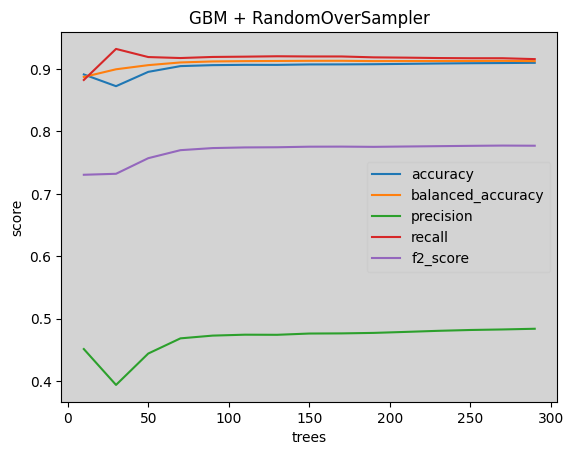

In [175]:
for i, metric in enumerate(metrics_names):
    plt.plot(trees, metrics_simple[:,i], label=metric)
plt.legend()
plt.xlabel('trees')
plt.ylabel('score')
plt.title('GBM + RandomOverSampler')

Далее чтобы повысить читабельность графиков, построим метрики на отдельных графиках

In [176]:
# SMOTE
for j, K in enumerate(neighbours):
    for i, N in enumerate(trees):
        model = GradientBoostingClassifier(n_estimators=N)
        pipe = Pipeline([('ct', ct),
                     ('resampler', SMOTE(random_state=rand_st, k_neighbors=K)),
                     ('model', model)])

        accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=3)
        for k, name in enumerate(metrics_names):
            metrics[j][i][k] = accur['test_' + name].mean()

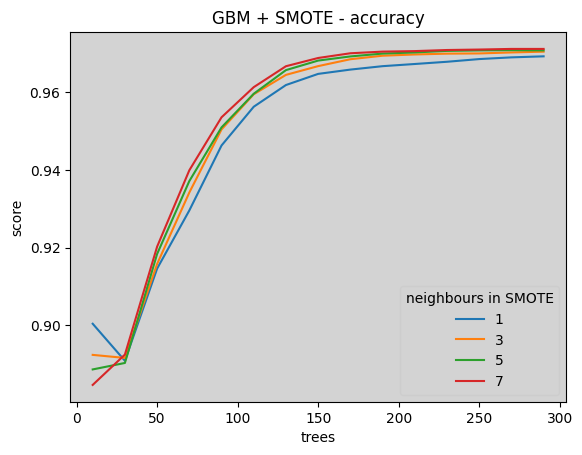

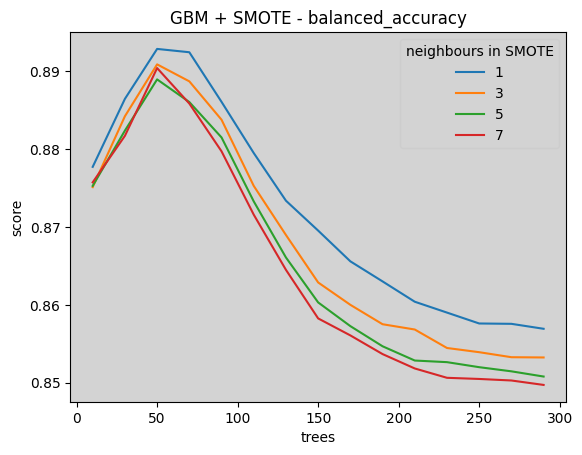

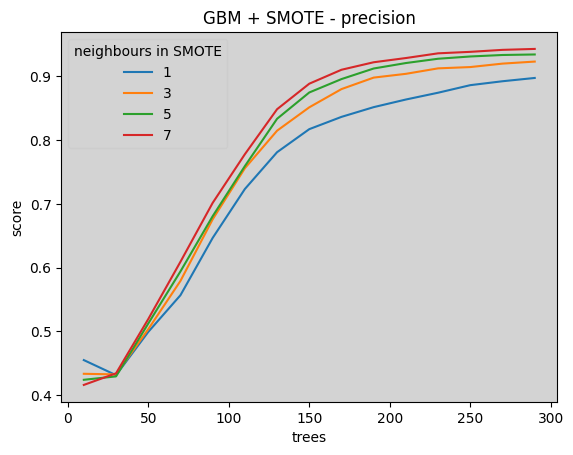

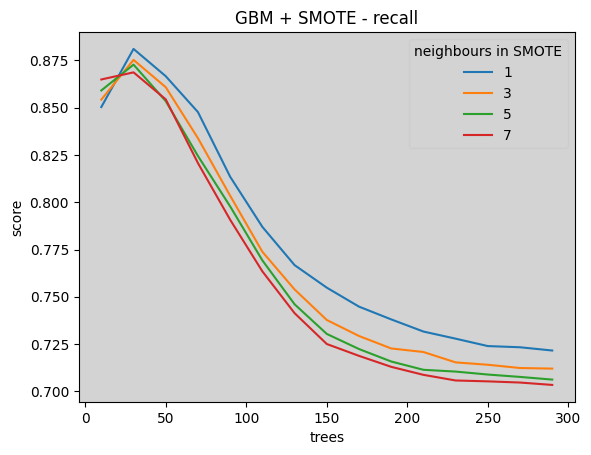

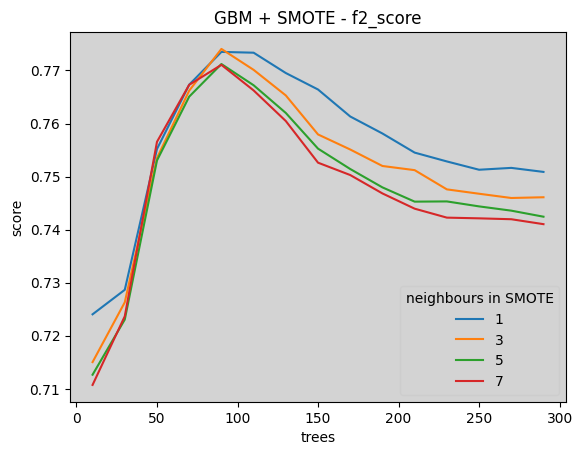

In [177]:
for i, metric in enumerate(metrics_names):
    for j, K in enumerate(neighbours):
        plt.plot(trees, metrics[j,:,i], label=str(K))
        plt.legend(title='neighbours in SMOTE')
        plt.xlabel('trees')
        plt.ylabel('score')
        plt.title('GBM + SMOTE - ' + metric)
    plt.show()

In [178]:
# ADASYN
for j, K in enumerate(neighbours):
    for i, N in enumerate(trees):
        model = GradientBoostingClassifier(n_estimators=N)
        pipe = Pipeline([('ct', ct),
                     ('resampler', ADASYN(random_state=rand_st, n_neighbors=K)),
                     ('model', model)])

        accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
        for k, name in enumerate(metrics_names):
            metrics[j][i][k] = accur['test_' + name].mean()

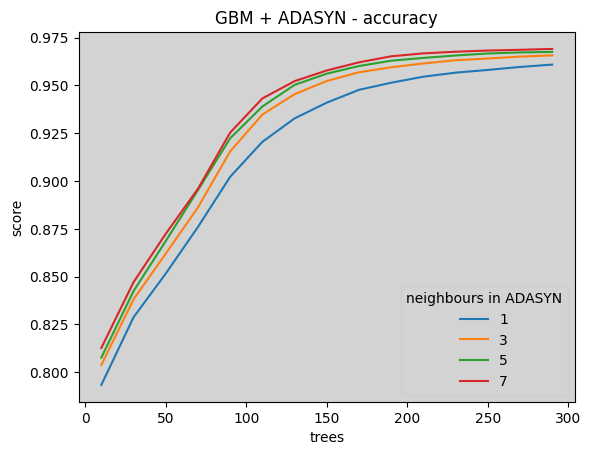

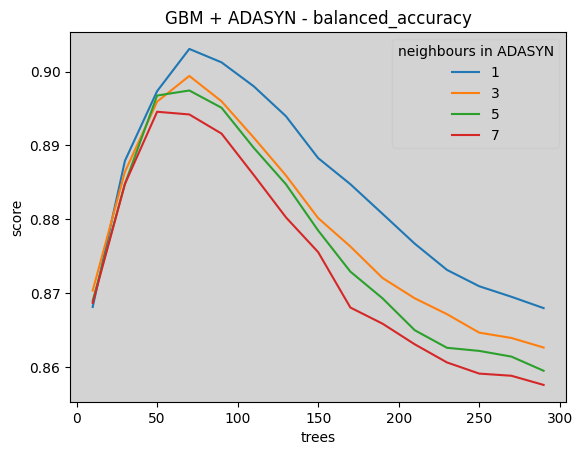

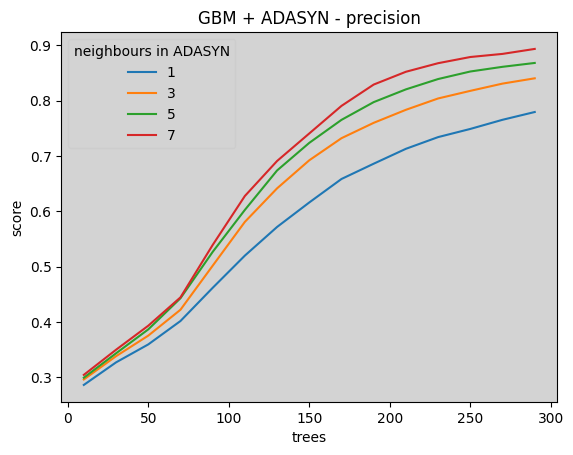

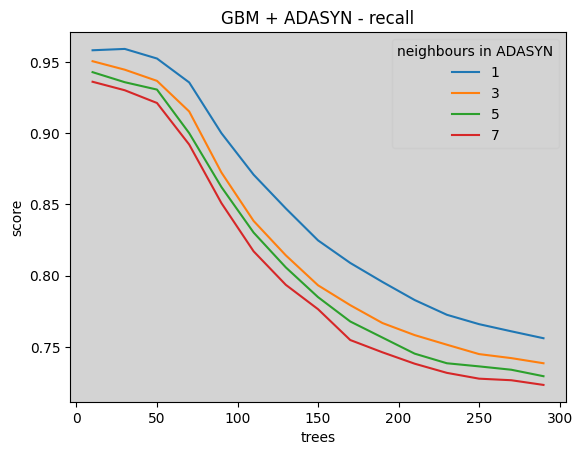

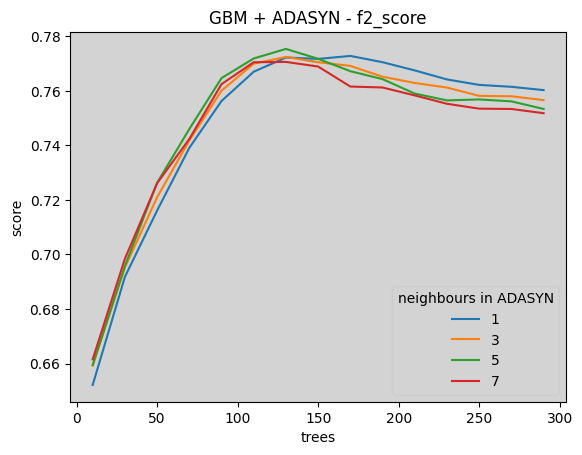

In [179]:
for i, metric in enumerate(metrics_names):
    for j, K in enumerate(neighbours):
        plt.plot(trees, metrics[j,:,i], label=str(K))
        plt.legend(title='neighbours in ADASYN')
        plt.xlabel('trees')
        plt.ylabel('score')
        plt.title('GBM + ADASYN - ' + metric)
    plt.show()

### 4.2 UnderSampling

In [180]:
# Random
for i, N in enumerate(trees):
    model = GradientBoostingClassifier(n_estimators=N)
    pipe = Pipeline([('ct', ct),
                 ('resampler', RandomUnderSampler(random_state=rand_st)),
                 ('model', model)])

    accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=5)
    for k, name in enumerate(metrics_names):
        metrics_simple[i][k] = accur['test_' + name].mean()

Text(0.5, 1.0, 'GBM + RandomUnderSampler')

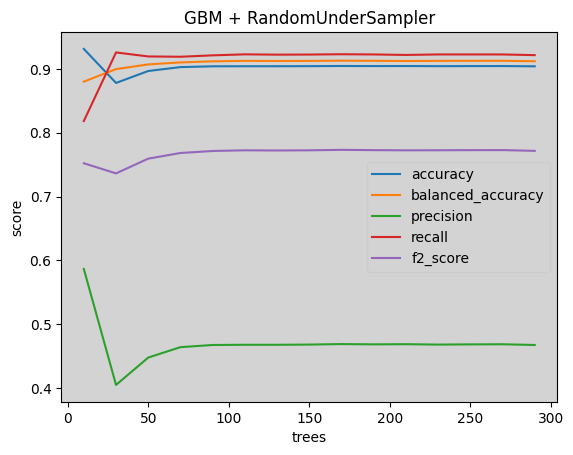

In [181]:
for i, metric in enumerate(metrics_names):
    plt.plot(trees, metrics_simple[:,i], label=metric)
plt.legend()
plt.xlabel('trees')
plt.ylabel('score')
plt.title('GBM + RandomUnderSampler')

### 4.3 Combination

In [182]:
# SMOTETomek
for j, K in enumerate(neighbours):
    for i, N in enumerate(trees):
        model = GradientBoostingClassifier(n_estimators=N)
        pipe = Pipeline([('ct', ct),
                     ('resampler', SMOTETomek(random_state=rand_st, smote=SMOTE(k_neighbors=K))),
                     ('model', model)])

        accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=3)
        for k, name in enumerate(metrics_names):
            metrics[j][i][k] = accur['test_' + name].mean()

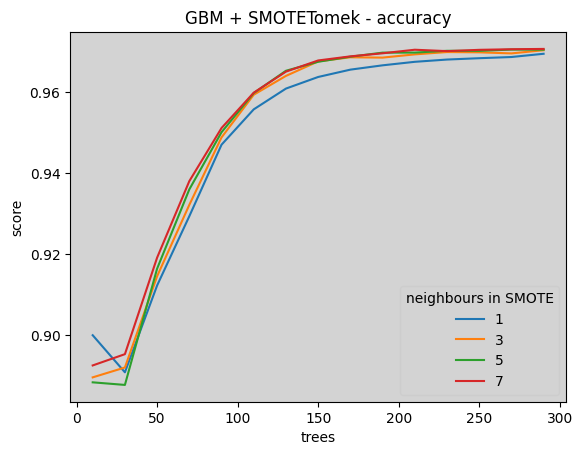

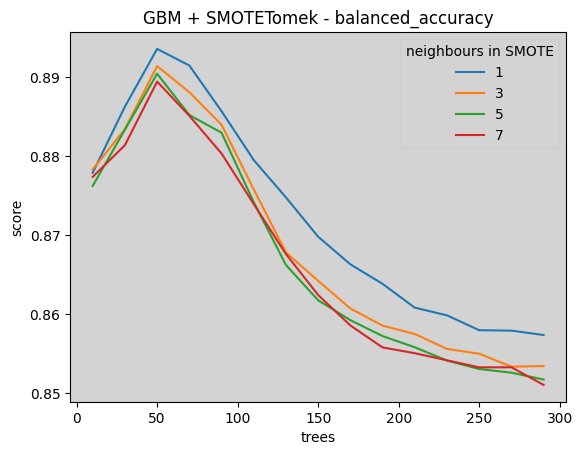

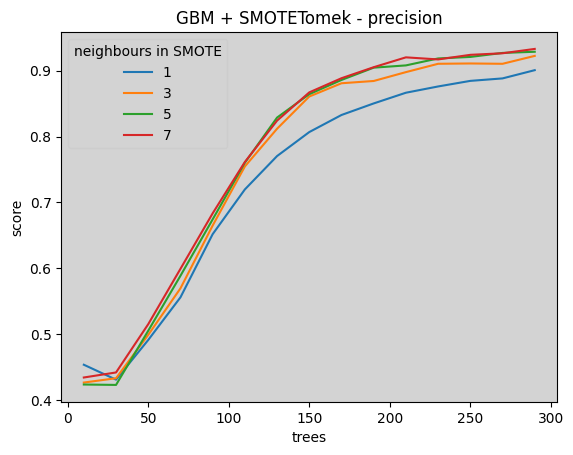

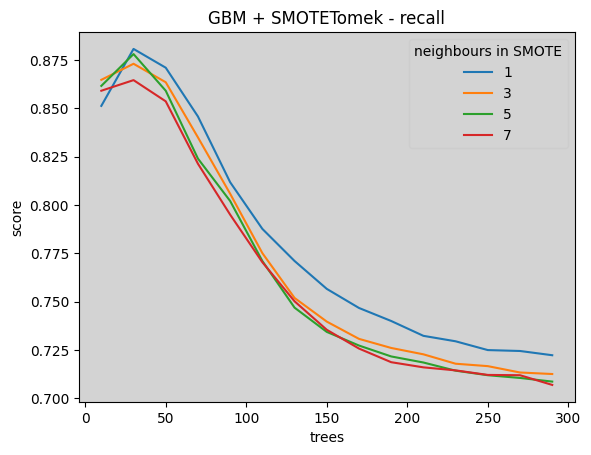

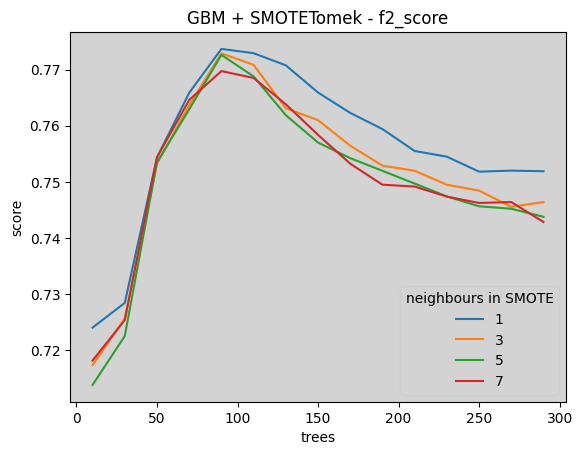

In [183]:
for i, metric in enumerate(metrics_names):
    for j, K in enumerate(neighbours):
        plt.plot(trees, metrics[j,:,i], label=str(K))
        plt.legend(title='neighbours in SMOTE')
        plt.xlabel('trees')
        plt.ylabel('score')
        plt.title('GBM + SMOTETomek - ' + metric)
    plt.show()

In [184]:
# SMOTEENN
for j, K in enumerate(neighbours):
    for i, N in enumerate(trees):
        model = GradientBoostingClassifier(n_estimators=N)
        pipe = Pipeline([('ct', ct),
                     ('resampler', SMOTEENN(random_state=rand_st, smote=SMOTE(k_neighbors=K))),
                     ('model', model)])

        accur = cross_validate(pipe, X_train, y_train, scoring=metrics_names, cv=3)
        for k, name in enumerate(metrics_names):
            metrics[j][i][k] = accur['test_' + name].mean()

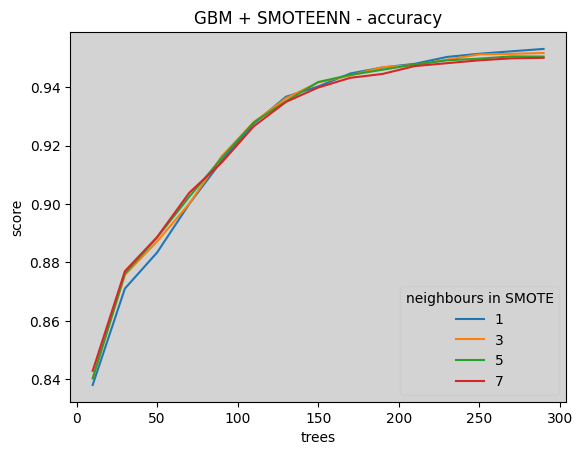

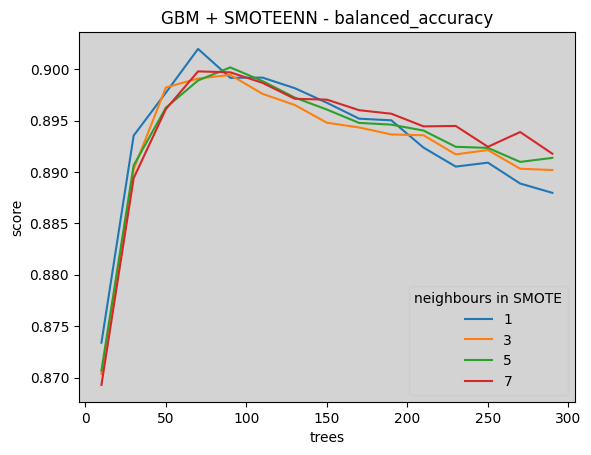

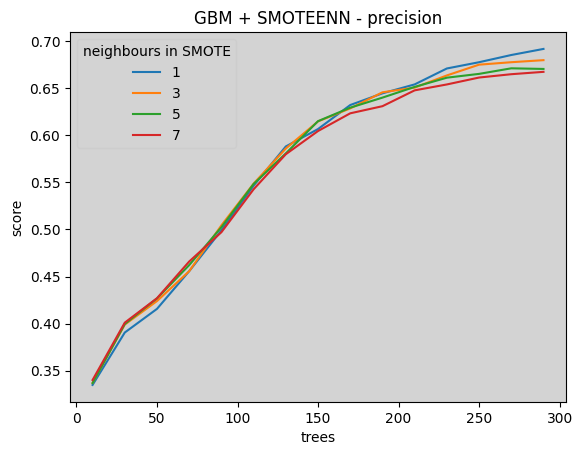

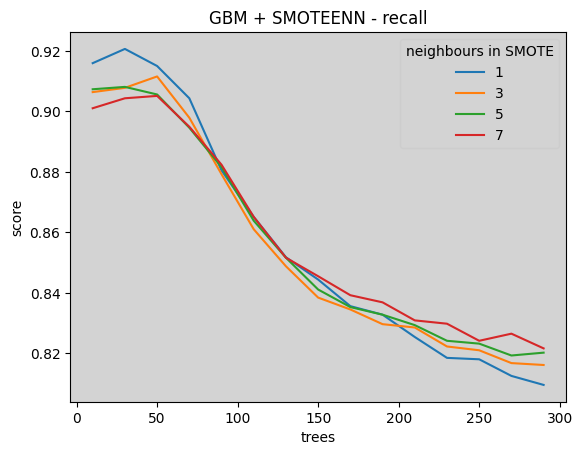

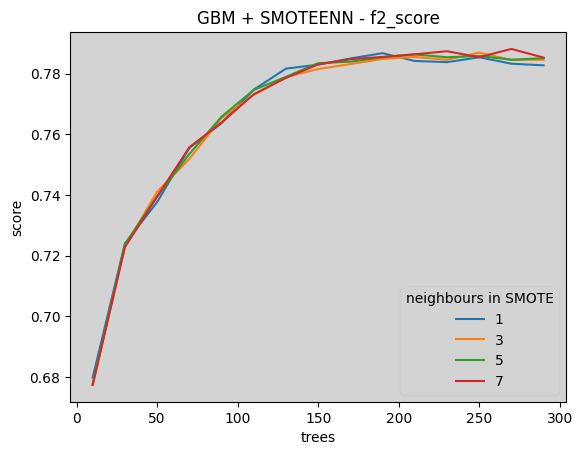

In [185]:
for i, metric in enumerate(metrics_names):
    for j, K in enumerate(neighbours):
        plt.plot(trees, metrics[j,:,i], label=str(K))
        plt.legend(title='neighbours in SMOTE')
        plt.xlabel('trees')
        plt.ylabel('score')
        plt.title('GBM + SMOTEENN - ' + metric)
    plt.show()

Видно, что алгоритмы совпадают по качеству, причем ведут себя 2мя образами: рандомизированные к 100 деревьям достигают максимума и не меняются, а у остальных на 100 деревьев приходится пик f2_score целевого признака (разве что у ADASYN чуть больше). Интересно, что SMOTEENN по поведению похож на случайные, причем максимума достигает на 200 деревьях. Выберем по одному из каждого типа, а также SMOTEENN и поварьируем решающий порог.

### 4.4 Выбор порога

In [189]:
from scikitplot.metrics import plot_roc, precision_recall_curve

model = GradientBoostingClassifier(n_estimators=100)
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=rand_st)

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

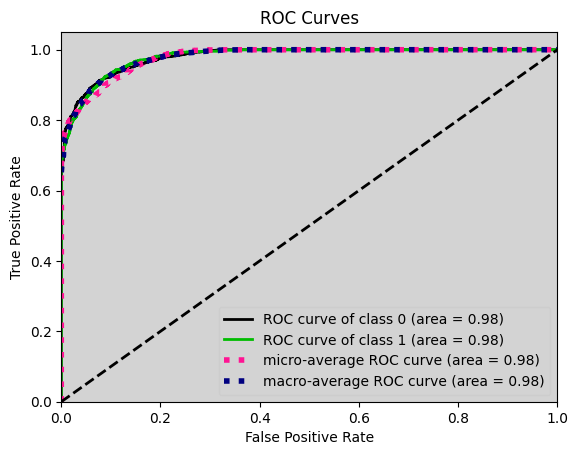

In [190]:
# Random

resampler = RandomOverSampler(random_state=rand_st)
pipe = Pipeline([('ct', ct),
                    ('resampler', resampler),
                    ('model', model)])

pipe.fit(X_train_s, y_train_s)
y_proba = pipe.predict_proba(X_val)
plot_roc(y_val, y_proba)

In [192]:
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:,1], pos_label=1)
mask = precision * recall > 0
precision, recall, thresholds = precision[mask], recall[mask], np.insert(thresholds, 0, 0)[mask]
beta = 2
fbeta = (1 + beta) * (precision * recall) / (beta * precision + recall) # unnormalized
best_rand = thresholds[fbeta.argmax()]

In [194]:
print(fbeta.max(), best_rand)

0.7874064837905236 0.7619981027665387


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

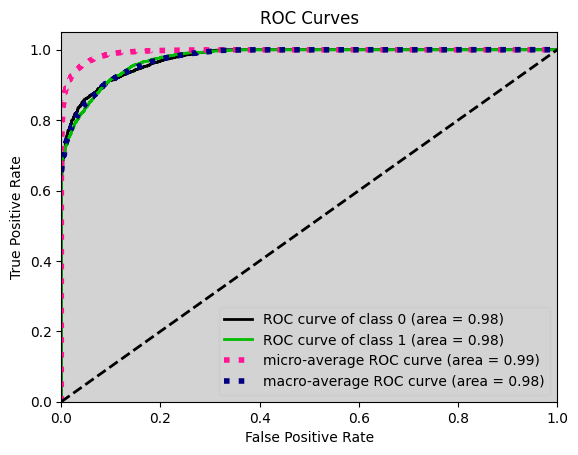

In [195]:
# SMOTE

resampler = SMOTE(random_state=rand_st)
pipe = Pipeline([('ct', ct),
                    ('resampler', resampler),
                    ('model', model)])

pipe.fit(X_train_s, y_train_s)
y_proba = pipe.predict_proba(X_val)
plot_roc(y_val, y_proba)

In [197]:
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:,1], pos_label=1)
mask = precision * recall > 0
precision, recall, thresholds = precision[mask], recall[mask], np.insert(thresholds, 0, 0)[mask]
beta = 2
fbeta = (1 + beta) * (precision * recall) / (beta * precision + recall) # unnormalized
best_sm = thresholds[fbeta.argmax()]

In [198]:
print(fbeta.max(), best_sm)

0.7732758620689655 0.5655462446902471


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

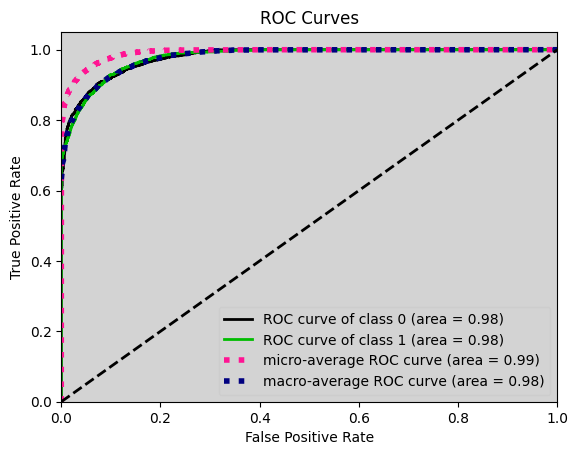

In [215]:
# SMOTEENN
model = GradientBoostingClassifier(n_estimators=200)

resampler = SMOTEENN(random_state=rand_st)
pipe = Pipeline([('ct', ct),
                    ('resampler', resampler),
                    ('model', model)])

pipe.fit(X_train_s, y_train_s)
y_proba = pipe.predict_proba(X_val)
plot_roc(y_val, y_proba)

In [216]:
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:,1], pos_label=1)
mask = precision * recall > 0
precision, recall, thresholds = precision[mask], recall[mask], np.insert(thresholds, 0, 0)[mask]
beta = 2
fbeta = (1 + beta) * (precision * recall) / (beta * precision + recall) # unnormalized
best_enn = thresholds[fbeta.argmax()]

In [217]:
print(fbeta.max(), best_enn)

0.7819314641744549 0.6547343884865394


Сравнивая roc-кривые: алгоритмы одинаково хорошо решают задачу. Однако случайный - самая простая модель из рассмотренных - показал себя чуть лучше при выборе оптимального порога - его и оставим.

### 5 Тестирование

In [208]:
model = GradientBoostingClassifier(n_estimators=100)
resampler = RandomOverSampler()
pipe = Pipeline([('ct', ct),
                    ('resampler', resampler),
                    ('model', model)]) 
pipe.fit(X_train, y_train)
y_pred = (pipe.predict_proba(X_test) > best_rand)[:,1]

In [211]:
print('accuracy: ', accuracy_score(y_test, y_pred))
print('balanced accuracy: ', balanced_accuracy_score(y_test, y_pred))
print('precision sick label: ', precision_score(y_test, y_pred, pos_label=1))
print('recall sick label: ', recall_score(y_test, y_pred, pos_label=1))
print('f2 score sick label: ', fbeta_score(y_test, y_pred, beta=2, pos_label=1))

accuracy:  0.9632
balanced accuracy:  0.8787219543555127
precision sick label:  0.7873152122079161
recall sick label:  0.7769411764705882
f2 score sick label:  0.7789940549212042
